<a href="https://colab.research.google.com/github/ImranNust/LungCancerDetection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import requests
from pathlib import Path
import zipfile
import shutil

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import plot_model
import sklearn

2022-11-25 18:43:43.928638: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
try:
    import tensorflow_addons as tfa
except:
    print('INFO: tenorflow_addons does not exist; therefore, installing it.')
    !pip install -U tensorflow-addons
    import tensorflow_addons as tfa


learning_rate = 0.00001 # original was 0.0001, and changed to 0.00001
weight_decay = 0.000001 # original was 0.00001 and changed to 0.000001
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

In [ ]:
# Parameters
target_size = (256, 256) # This is the size our image datagenerator will convert into
batch_size = 32
epochs = 2
input_shape = (256, 256, 3) #This is the shape we will get from folders
patch_size = 16
projection_dim= 768 # This is the projection dimension
num_of_patches = int(input_shape[0]/patch_size * input_shape[1]/patch_size)
num_of_heads = 2
num_of_blocks = 4
num_of_classes = 3

In [ ]:
data_path = '/gpfs/space/home/imranmuh/LungCancerDetection/'


history_dir = '/gpfs/space/home/imranmuh/LungCancerDetection/history_ver9'
history_filename = '/gpfs/space/home/imranmuh/LungCancerDetection/history_ver9/training_ver9_new.csv'

best_model_checkpoint_filename = '/gpfs/space/home/imranmuh/LungCancerDetection/ver9/Best_Model/best_model_checkpoint.ckpt'
training_model_checkpoint_filename = '/gpfs/space/home/imranmuh/LungCancerDetection/ver9/TrainingModel/training_model_checkpoint.ckpt'

# # Defining Callbacks

# Following checkpoint is to save the best model
BestModelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath = best_model_checkpoint_filename,
                                                             monitor = "val_loss",
                                                             verbose  = 1,
                                                             save_best_only = True,
                                                             save_weights_only = True,
                                                             mode = "min",
                                                             save_freq="epoch",
                                                             )
# Following checkpoint is to save the model for every epoch, so that we can use it to resume the training
TrainingModelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath = training_model_checkpoint_filename,
                                                             monitor = "val_loss",
                                                             verbose  = 1,
                                                             save_best_only = False,
                                                             save_weights_only = True,
                                                             mode = "min",
                                                             save_freq="epoch",
                                                             )
# saving the history after every epoch
CSVLoggerCallback = tf.keras.callbacks.CSVLogger(filename = history_filename,
                                                 separator = ',',
                                                 append = 'True')

callbacks = [BestModelCheckpoint, TrainingModelCheckpoint, CSVLoggerCallback]

In [ ]:
if os.path.isfile(Path(data_path) / 'DatasetFor32BatchSize.zip'):
    # Unzip the downloaded data
    with zipfile.ZipFile(Path(data_path) / "DatasetFor32BatchSize.zip", "r") as zip_ref:
        print("Uzipping the data...")
        zip_ref.extractall(Path(data_path))
        # Remove the zip file
        os.remove(Path(data_path) / 'DatasetFor32BatchSize.zip')
else:
    print('Either the zip folder doesnot exist, OR you have already extracted it.')


Either the zip folder doesnot exist, OR you have already extracted it.


In [ ]:
try: 
    from utilities.DataProcessing import generate_iterator, display_images
    from utilities.VisionTransformer import PatchExtractor, PatchEncoder, MLP
    from utilities.VisionTransformer import  Block, TransformerEncoder
    from utilities.ConvolutionalNeuralNetworks import CNNLayers, FeatureSelectionBlock, BottleneckBlock
    from utilities.metrics import CustomConfusionMatrix, CustomAccuracy
    from utilities.metrics import CustomPrecision, CustomRecall
    from utilities.metrics import CustomSpecificity, CustomF1Score
    from utilities.plot_metrics import plot_metrics, plot_roc
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find utilties folder... downloading them from GitHub.")
    !git clone https://github.com/ImranNust/LungCancerDetection
    !mv LungCancerDetection/utilities/ .
    # !mv LungCancerDetection/helper_functions.py . # get the helper_functions.py script
    !rm -rf LungCancerDetection
    from utilities.DataProcessing import generate_iterator, display_images
    from utilities.VisionTransformer import PatchExtractor, PatchEncoder, MLP
    from utilities.VisionTransformer import  Block, TransformerEncoder
    from utilities.ConvolutionalNeuralNetworks import CNNLayers, FeatureSelectionBlock, BottleneckBlock
    from utilities.metrics import CustomConfusionMatrix, CustomAccuracy
    from utilities.metrics import CustomPrecision, CustomRecall
    from utilities.metrics import CustomSpecificity, CustomF1Score
    from utilities.plot_metrics import plot_metrics, plot_roc

Generating the iterator without performing augmenation...
Found 12096 images belonging to 3 classes.


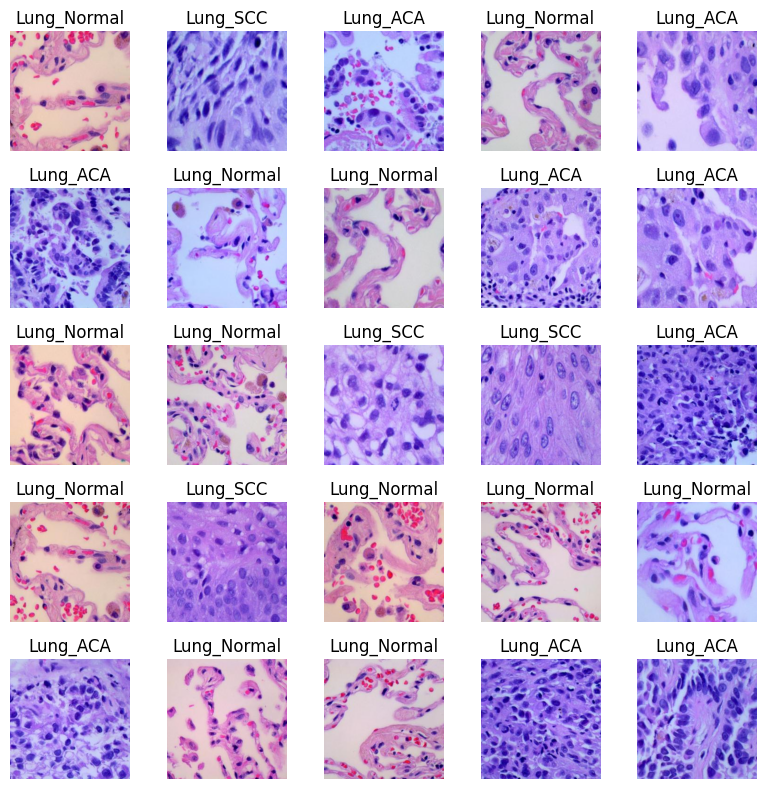

In [ ]:
data_dir = Path(data_path) / 'DatasetFor32BatchSize'
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'


train_iterator = generate_iterator(path = train_dir, augmentation = False, color_mode = 'rgb', 
                                   batch_size = batch_size, shuffle = True, target_size = target_size,
                                   seed = None, interpolation = 'bilinear', rescale = 1/255.0)

train_iterator.class_indices
display_images(train_iterator)

Generating the iterator without performing augmenation...
Found 1440 images belonging to 3 classes.


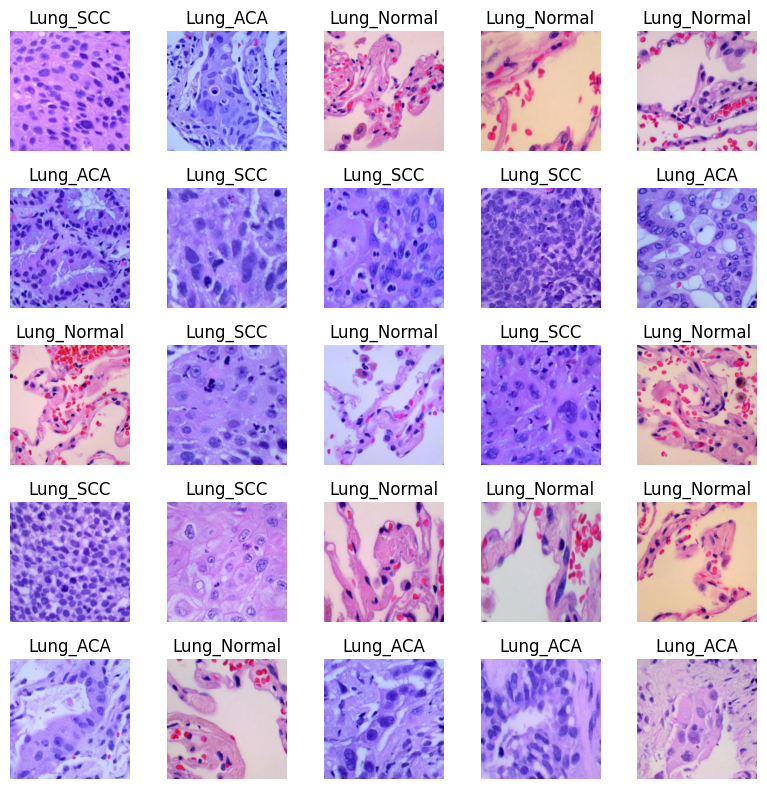

In [ ]:
val_iterator = generate_iterator(path = val_dir, augmentation = False, color_mode = 'rgb', 
                                   batch_size = batch_size, shuffle = True, target_size = target_size,
                                   seed = None, interpolation = 'bilinear', rescale = 1/255.0)

val_iterator.class_indices
display_images(val_iterator)

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print('Device Used for Training: {}'.format(physical_devices))
tf.config.experimental.get_memory_growth(physical_devices[0])

Device Used for Training: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
def final_model(input_shape, 
                patch_size,
                filters = 16,
                kernel_size = 3,
                Normalization = 'layer_normalization', 
                num_classes = num_of_classes,
                dropout_rate = 0.1,
                batch_size = batch_size):
    
    inputs = Input(shape = input_shape)
    
    ############################### Layer 0 #################################
    Layer0_PE = PatchExtractor(patch_size= patch_size,
                               batch_size = batch_size,
                               input_shape = input_shape)
    Layer0_PE_Output = Layer0_PE(inputs)

    
    ############################### Layer 1 ##################################
    Layer1_RB_Output = FeatureSelectionBlock(inputs, blocks = 3,
                                      filter_bank = [16  , 16, 32], kernel_size = 3,
                                      strides = 1, Normalization = 'layer_normalization')
    Layer1_TB_Output = BottleneckBlock(Layer1_RB_Output, filter_bank = [16, 16, 32], kernel_size = 3,
                                        strides = 2, Normalization = 'layer_normalization')
    
    Layer1_PE = PatchExtractor(patch_size= patch_size//2,
                               batch_size = batch_size,
                               input_shape = Layer1_TB_Output.shape[1:])
    Layer1_PE_Output = Layer1_PE(Layer1_TB_Output)

    
    ############################### Layer 2 ##################################
    Layer2_RB_Output = FeatureSelectionBlock(Layer1_TB_Output, blocks = 3,
                                      filter_bank = [16  , 16, 32], kernel_size = 3,
                                      strides = 1, Normalization = 'layer_normalization')
    Layer2_TB_Output = BottleneckBlock(Layer2_RB_Output, filter_bank = [16, 16, 32], kernel_size = 3,
                                        strides = 2, Normalization = 'layer_normalization')
    
    Layer2_PE = PatchExtractor(patch_size= patch_size//4,
                               batch_size = batch_size,
                               input_shape = Layer2_TB_Output.shape[1:])
    Layer2_PE_Output = Layer2_PE(Layer2_TB_Output)

    ############################### Layer 3 ##################################
    
    Layer3_RB_Output = FeatureSelectionBlock(Layer2_TB_Output, blocks = 3,
                                      filter_bank = [16  , 16, 32], kernel_size = 3,
                                      strides = 1, Normalization = 'layer_normalization')
    Layer3_TB_Output = BottleneckBlock(Layer3_RB_Output, filter_bank = [16, 16, 32], kernel_size = 3,
                                        strides = 2, Normalization = 'layer_normalization')
    
    Layer3_PE = PatchExtractor(patch_size= patch_size//8,
                               batch_size = batch_size,
                               input_shape = Layer3_TB_Output.shape[1:])
    Layer3_PE_Output = Layer3_PE(Layer3_TB_Output)
    # concatenate_output = tf.keras.layers.Concatenate(axis = -1)([Layer0_PE_Output,
    #                                                              Layer1_PE_Output, 
    #                                                              Layer2_PE_Output,
    #                                                              Layer3_PE_Output])
#     Layer3_PEncoder = PatchEncoder(patch_size = patch_size,
#                                    batch_size = batch_size,
#                                    input_shape = input_shape)
    
#     Layer3_PEncoder_Output = Layer3_PEncoder(concatenate_output)
#     
#     input_for_transformer = Layer3_PEncoder_Output
    ############################### Layer 4 ##################################
    Layer4_RB_Output = FeatureSelectionBlock(Layer3_TB_Output, blocks = 3,
                                      filter_bank = [16  , 16, 32], kernel_size = 3,
                                      strides = 1, Normalization = 'layer_normalization')
    Layer4_TB_Output = BottleneckBlock(Layer4_RB_Output, filter_bank = [16, 16, 32], kernel_size = 3,
                                        strides = 2, Normalization = 'layer_normalization')
    
    Layer4_PE = PatchExtractor(patch_size= patch_size//16,
                               batch_size = batch_size,
                               input_shape = Layer4_TB_Output.shape[1:])
    Layer4_PE_Output = Layer4_PE(Layer4_TB_Output)
    concatenate_output = tf.keras.layers.Concatenate(axis = -1)([Layer0_PE_Output,
                                                                 Layer1_PE_Output, 
                                                                 Layer2_PE_Output,
                                                                 Layer3_PE_Output,
                                                                 Layer4_PE_Output])
    Layer4_PEncoder = PatchEncoder(patch_size = patch_size,
                                   batch_size = batch_size,
                                   input_shape = input_shape)
    
    Layer4_PEncoder_Output = Layer4_PEncoder(concatenate_output)
    
    input_for_transformer = Layer4_PEncoder_Output
    
    ########################## Transformormer Layer #############################
    transformer1 = TransformerEncoder(patch_size = patch_size,
                                      batch_size = batch_size,
                                      input_shape = input_shape,
                                      num_heads = 4,
                                      num_blocks = 12,
                                      dropout_rate = 0.1)
    transformer1_output = transformer1(input_for_transformer)
    
    output = GlobalAveragePooling1D()(transformer1_output)
    
    # MLP to classify outputs
    mlp = MLP(projection_dim, 128, dropout_rate = dropout_rate)
    logits = mlp(output)
    # # Create model
    outputs = Dense(num_classes, activation='softmax')(logits)
    model = Model(inputs = inputs, outputs = outputs)
    return model




In [ ]:
metrics = [CustomAccuracy, CustomRecall, CustomPrecision, CustomSpecificity, CustomF1Score]

In [ ]:


# if os.path.exists(model_dir) and len(os.listdir(model_dir))!=0:
#     try:
#         print('The directory is not empty; therefore loading the existing model')
#         model = tf.keras.models.load_model(model_dir)
#     except:
#         print('No model exists; therefore, creating one')
#         model = final_model(input_shape = input_shape, 
#                              patch_size = patch_size,
#                              filters = 16,
#                              kernel_size = 3,
#                              Normalization = 'layer_normalization',   
#                              num_classes = num_of_classes,
#                              dropout_rate = 0.1)
#         model.compile(optimizer=optimizer,
#                       loss=tf.keras.losses.CategoricalCrossentropy(),
#                       metrics= metrics)
# else:
#     print('Either directory is emtpy or model do not exist; therefore, creating one...')
#     model = final_model(input_shape = input_shape, 
#                         patch_size = patch_size,
#                         filters = 16,
#                         kernel_size = 3,
#                         Normalization = 'layer_normalization',   
#                         num_classes = num_of_classes,
#                         dropout_rate = 0.1)

model = final_model(input_shape = input_shape, 
                    patch_size = patch_size,
                    filters = 16,
                    kernel_size = 3,
                    Normalization = 'layer_normalization',     
                    num_classes = num_of_classes,
                    dropout_rate = 0.1)
model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics= metrics)



model.summary()

2022-11-23 09:51:31.171075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 09:51:33.004846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 layer_normalization (LayerNorm  (None, 256, 256, 16  32         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# steps_per_epoch  =  total training samples by batch size chosen
steps_per_epoch = 10
history = model.fit(train_iterator,
                    batch_size=batch_size,
                    epochs=30,
                    validation_data = val_iterator,
                    validation_batch_size = batch_size,
                    callbacks = callbacks)


Epoch 1/30


2022-11-23 09:52:02.509909: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


378/378 [==============================] - ETA: 0s - loss: 0.4258 - CustomAccuracy: 0.8699 - CustomRecall: 0.8053 - CustomPrecision: 0.8156 - CustomSpecificity: 0.9018 - CustomF1Score: 0.7913
Epoch 1: val_loss improved from inf to 0.28062, saving model to /gpfs/space/home/imranmuh/LungCancerDetection/ver9/Best_Model/best_model_checkpoint.ckpt

Epoch 1: saving model to /gpfs/space/home/imranmuh/LungCancerDetection/ver9/TrainingModel/training_model_checkpoint.ckpt
378/378 [==============================] - 755s 2s/step - loss: 0.4258 - CustomAccuracy: 0.8699 - CustomRecall: 0.8053 - CustomPrecision: 0.8156 - CustomSpecificity: 0.9018 - CustomF1Score: 0.7913 - val_loss: 0.2806 - val_CustomAccuracy: 0.9343 - val_CustomRecall: 0.9012 - val_CustomPrecision: 0.9053 - val_CustomSpecificity: 0.9502 - val_CustomF1Score: 0.8992
Epoch 2/30
378/378 [==============================] - ETA: 0s - loss: 0.2638 - CustomAccuracy: 0.9259 - CustomRecall: 0.8890 - CustomPrecision: 0.8942 - CustomSpecificity:

In [ ]:
# # To Resume the Training, we will do the following

# model1 = final_model(input_shape = input_shape, 
#                     patch_size = patch_size,
#                     filters = 16,
#                     kernel_size = 3,
#                     Normalization = 'layer_normalization',     
#                     num_classes = num_of_classes,
#                     dropout_rate = 0.1)
# model1.compile(optimizer=optimizer,
#                   loss=tf.keras.losses.CategoricalCrossentropy(),
#                   metrics= metrics)
# model1.load_weights(training_model_checkpoint_filename)
# history = model1.fit(train_iterator,
#                     batch_size=batch_size,
#                     epochs=15,
#                     validation_data = val_iterator,
#                     validation_batch_size = batch_size,
#                     callbacks = callbacks)

In [ ]:
# To get the results for test data, we will do the following
model2 = final_model(input_shape = input_shape, 
                    patch_size = patch_size,
                    filters = 16,
                    kernel_size = 3,
                    Normalization = 'layer_normalization',     
                    num_classes = num_of_classes,
                    dropout_rate = 0.1)
model2.compile(optimizer=optimizer,
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics= metrics)
model2.load_weights(best_model_checkpoint_filename)

test_iterator = generate_iterator(path = test_dir, augmentation = False, color_mode = 'rgb', 
                                   batch_size = batch_size, shuffle = True, target_size = target_size,
                                   seed = None, interpolation = 'bilinear', rescale = 1/255.0)

# val_iterator.class_indices
# display_images(val_iterator)
test_results = model2.evaluate(test_iterator)

2022-11-25 18:44:39.127624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 18:44:41.699350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3d:00.0, compute capability: 7.0


Generating the iterator without performing augmenation...
Found 1440 images belonging to 3 classes.


2022-11-25 18:45:12.354795: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


45/45 [==============================] - 50s 745ms/step - loss: 0.0485 - CustomAccuracy: 0.9875 - CustomRecall: 0.9815 - CustomPrecision: 0.9802 - CustomSpecificity: 0.9906 - CustomF1Score: 0.9796


1/1 [==============================] - 4s 4s/step


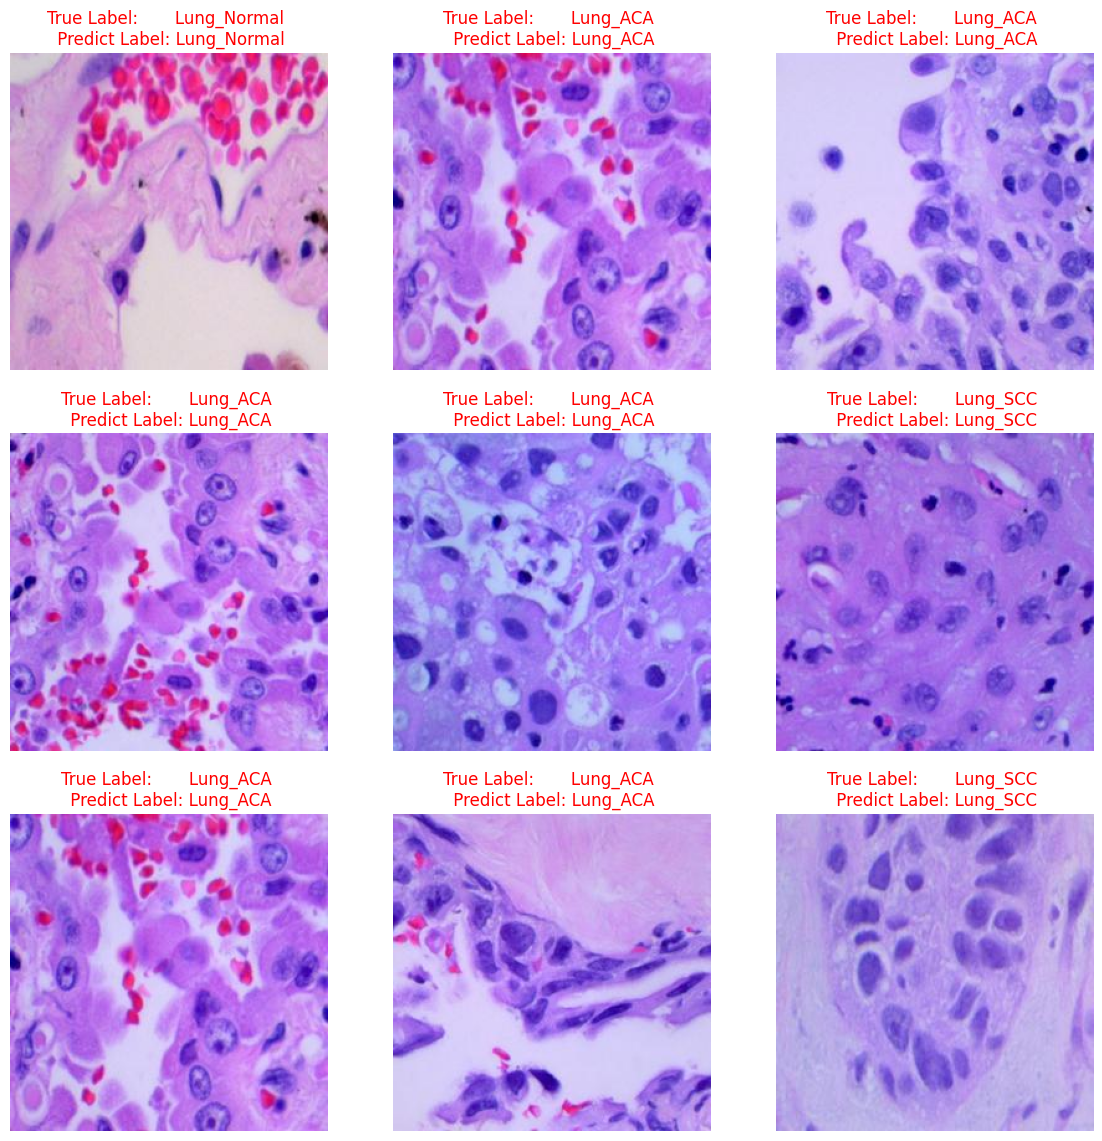

In [ ]:
# readiing 32 random images from test directory
import random
test_images, true_labels = test_iterator.next()
pred_labels = model2.predict(test_images)
classes = list(test_iterator.class_indices)
plt.figure(figsize = (14, 14))
for i in range(0, 9):
    rnd_img = np.random.choice(32)
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[rnd_img,...])
    text = 'True Label:       {} \n Predict Label: {}'.format(classes[np.argmax(true_labels[rnd_img])], classes[np.argmax(pred_labels[rnd_img])])
    plt.title(text, color = 'red')
    plt.axis(False)

In [ ]:
test_iterator = generate_iterator(path = test_dir, augmentation = False, color_mode = 'rgb', 
                                   batch_size = batch_size, shuffle = False, target_size = target_size,
                                   seed = None, interpolation = 'bilinear', rescale = 1/255.0)
test_predictions = model2.predict(test_iterator, batch_size=batch_size)
y_test = tf.keras.utils.to_categorical(test_iterator.labels)
y_score = test_predictions

Generating the iterator without performing augmenation...
Found 1440 images belonging to 3 classes.
45/45 [==============================] - 34s 677ms/step


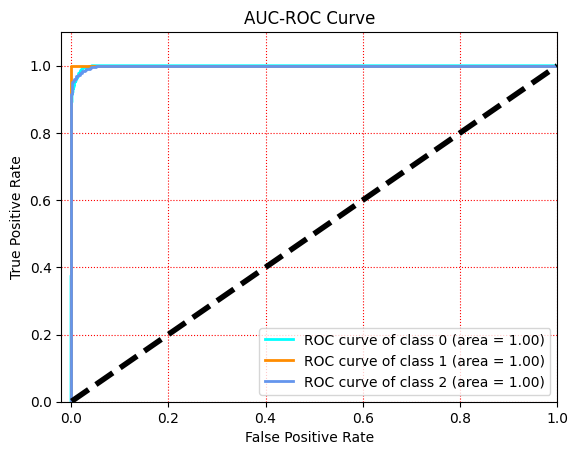

In [ ]:
plot_roc(y_test, y_score, 3)

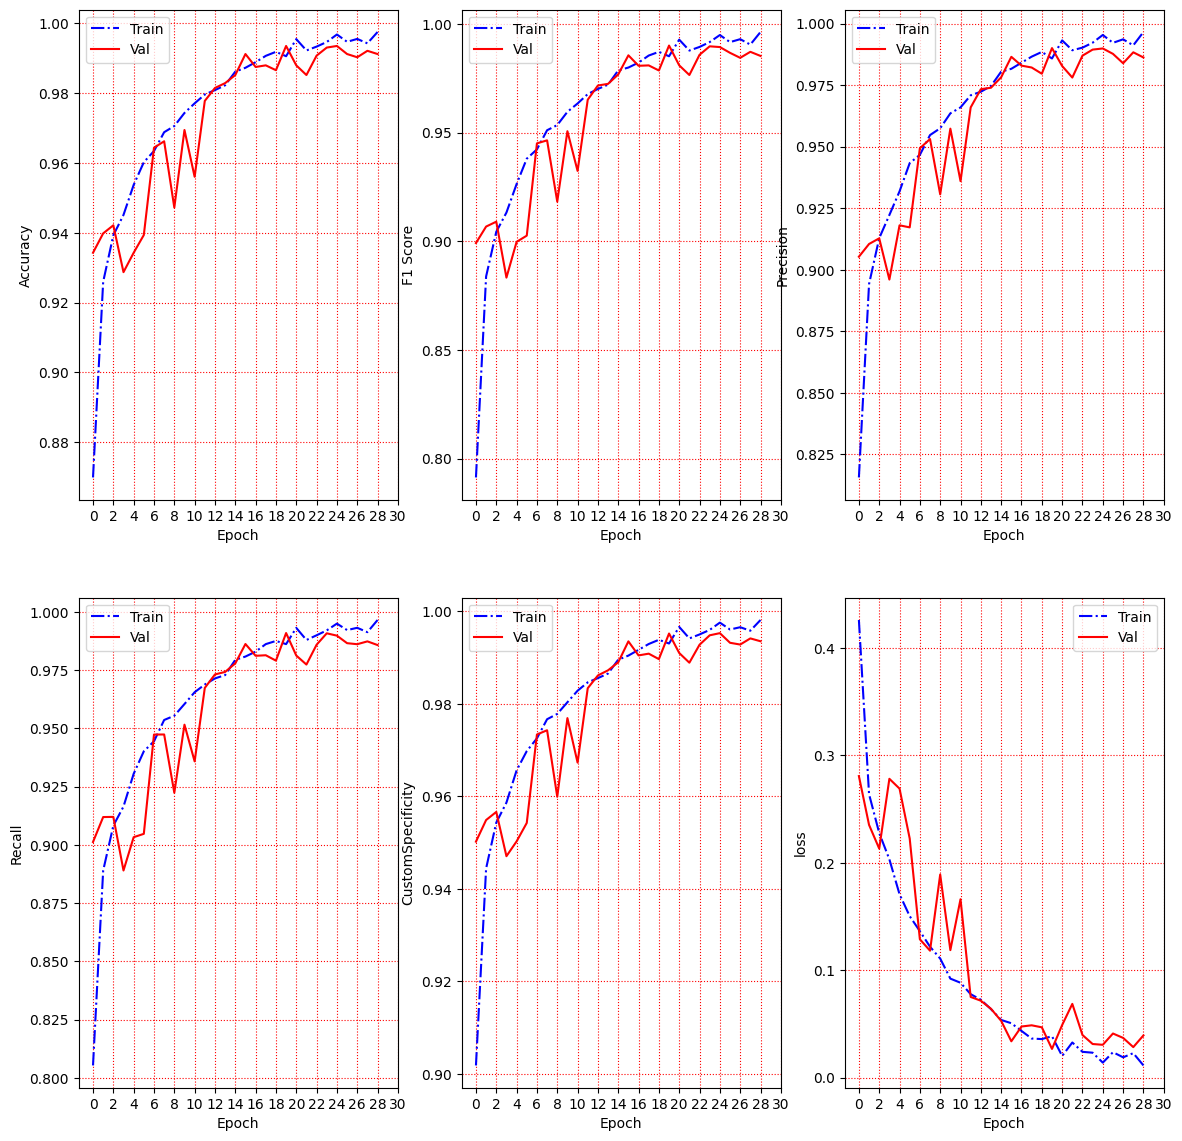

In [ ]:
plot_metrics(history_filename)